# MRI Neuroimaging Data Exploration and Masking with NiBabel and Nilearn
## Isadora Sinha

Firstly, ensure NiBabel and Nilearn are installed:

In [1]:
conda install -c conda-forge nibabel

Solving environment: done

# All requested packages already installed.


Note: you may need to restart the kernel to use updated packages.


In [31]:
pip install -U --user nilearn

     |████████████████████████████████| 3.0 MB 4.3 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


Install the required libraries:

In [24]:
import nibabel as nib
import numpy as np
import seaborn as sns
import nilearn
from nilearn import plotting
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
%matplotlib inline

The image object is now loaded using NiBabel's load function which requires a input of a NIfTI file and creates a NiBabel image object. As my project's MRI data is not cropped nor masked yet, example data of the same format is used. Example data obtained from https://www.fmrib.ox.ac.uk/primers/intro_primer/ExBox14/ExBox14.zip. 


In [25]:
example_image1 = nib.load('/Users/isadorasinha/Documents/Data_Science_&_Machine_Learning_Module/ExBox14/T1_brain.nii')
# Ensure single quotation marks are around the specified filepath - alter to where your ExBox14 EPI brain image is located.

Next, check the dimensions of the file to ensure the image file is the correct size range (good to check before any processing). The output is in the x, y, z dimensions of the voxels. 

In [26]:
example_image1.shape

(290, 320, 208)

This next step checks the data type:

In [27]:
example_image1.get_data_dtype()

dtype('<f4')

To load the actual image data, the get_data funtion is used:

In [28]:
example_data1 = example_image1.get_fdata()
# get_data() function was deprecated thus all data is loaded in this script uses the get_fdata() function 

Double check that the shape is the same as the voxel dimensions previously reported:

In [29]:
example_data1.shape

(290, 320, 208)

I can confirm the object is 3D and now the voxel dimensions. To show it graphically, the nilearn epi plotting function is utilised:

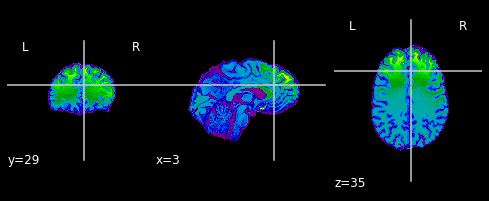

In [30]:
nilearn.plotting.plot_epi(epi_img='/Users/isadorasinha/Documents/Data_Science_&_Machine_Learning_Module/ExBox14/T1_brain.nii')
# Ensure single quotation marks are around the specified filepath - alter to where your ExBox14 EPI brain image is located.

Below I have also plotted the original MRI that was uncropped - this would not have been suitable to do the masking against.

/Users/isadorasinha/.local/lib/python3.8/site-packages/nilearn/image/resampling.py:512: UserWarning: Casting data from int32 to float32
  warnings.warn("Casting data from %s to %s" % (data.dtype.name, aux))


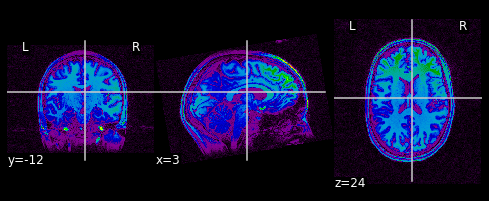

In [31]:
nilearn.plotting.plot_epi(epi_img='/Users/isadorasinha/Documents/Data_Science_&_Machine_Learning_Module/ExBox14/T1.nii')
# Ensure single quotation marks are around the specified filepath - alter to where your ExBox14 EPI head image is located.

The 3D data is hard to manipulate and work with thus it can be turned into 2d array which is made of the number of voxels by the number of volumes. Then the shape of the dimensions of this 2D object is displayed.

In [32]:
example_data1_2d = example_data1.reshape(np.prod(example_data1.shape[:-1]), example_data1.shape[-1])
example_data1_2d.shape

(92800, 208)

The following parts requires working with a mask - my project did not have one yet thus the example brain image and mask data was used. The mask image then data was loaded.

In [33]:
#example_mask_image1 = nib.load('/Users/isadorasinha/Documents/Data_Science_&_Machine_Learning_Module/ExBox14/T1_brain_mask.nii')
#example_mask_data1 = np.asanyarray(example_mask_image1)
#above code worked unexpectedly so was replaced with code below

In [34]:
example_mask_image1 = nib.load('/Users/isadorasinha/Documents/Data_Science_&_Machine_Learning_Module/ExBox14/T1_brain_mask.nii')
# Ensure single quotation marks are around the specified filepath - alter to where your ExBox14 mask image is located.
#example_mask_image1.shape
example_mask_data1 = example_mask_image1.get_fdata()
example_mask_data1.shape

(290, 320, 208)

Next the mask data was set to boolean to ensure each voxel is either True or False.

In [35]:
example_mask_data_b = example_mask_data1.astype(bool)
example_mask_data_b.shape

(290, 320, 208)

The boolean mask is then applied to the image data:

In [36]:
example_data1_masked = example_data1[example_mask_data_b]
example_data1_masked.shape
# square backets [] to index, not round brackets ()

(2718075,)

[64. 57. 40. ...  8. 36. 29.]


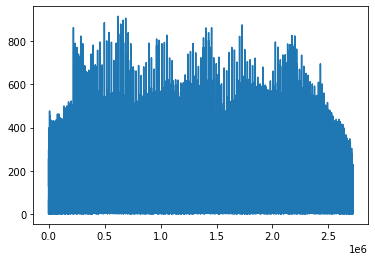

In [37]:
plt.plot(example_data1_masked)
array_values_data1 = list(example_data1_masked)
print(example_data1_masked)
# Can save array values list locally

The above was expoloring example data from one MRI image. Below, an example MRI dataset will be downloaded to show visualisation of volumes as can be applied to my MRI data after cropping and masking. 

In [38]:
from nilearn import datasets

Data from subject 2 (Haxby et al. 2001) is retrieved and the information about the dataset is printed for convenience:

In [39]:
haxby_dataset = datasets.fetch_haxby()

print('Location of first anatomical NIfTI image (3D): %s' %
      haxby_dataset.anat[0])
print('Location of first functional NIfTI image (4D): %s' %
      haxby_dataset.func[0])

Location of first anatomical NIfTI image (3D): /Users/isadorasinha/nilearn_data/haxby2001/subj2/anat.nii.gz
Location of first functional NIfTI image (4D): /Users/isadorasinha/nilearn_data/haxby2001/subj2/bold.nii.gz


To visualise an image that represents the whole dataset, the mean of axis 3 (time) of the MRI images are calculated and plotted using the same plot.epi function used previously:

(40, 64, 64)

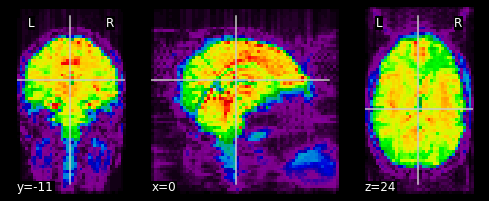

In [40]:
from nilearn.image.image import mean_img

intermediate_file = haxby_dataset.func[0]
haxby_mean = mean_img(intermediate_file)

from nilearn.plotting import plot_epi, show
plot_epi(haxby_mean)

haxby_mean.shape

This dataset does not come with mask files - masks can be generated utilsiing Nilearn's masking function of compute_epi_function:

In [41]:
from nilearn.masking import compute_epi_mask
mask_haxby = compute_epi_mask(intermediate_file)

This can now be visualised as a region of interest (ROI):

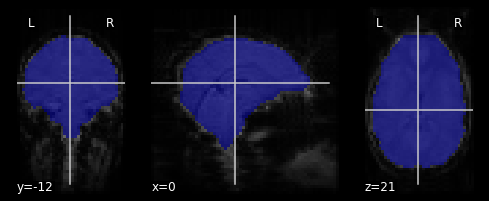

In [42]:
from nilearn.plotting import plot_roi
plot_roi(mask_haxby, haxby_mean)
# mask should cover our region of interest - the entire brain

So now the data is loaded and the mask has been generated, the mask can be applied to extract the corresponding time series using the apply_mask function:

In [43]:
from nilearn.masking import apply_mask
masked_data = apply_mask(intermediate_file, mask_haxby)
masked_data.shape

(1452, 24083)

This 2D masked_data object contains the timepoints and the voxels which can be plotted. Here is the code to plot the first 500 timepoints from 5 voxels:

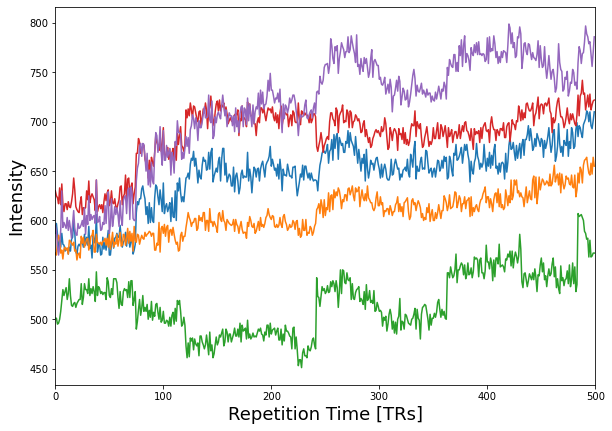

In [44]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.plot(masked_data[:500, :5])
plt.xlabel('Repetition Time [TRs]', fontsize=18)
plt.ylabel('Intensity', fontsize=18)
plt.xlim(0, 500)
plt.subplots_adjust(bottom=.15, top=.90, right=.90, left=.15)

show()

#Plot can be edited to show different number of timepoints and voxels by editing the third line in this chunk -
# e.g. for plotting 10 voxels at the first 200 timepoints, that line should read:
# plt.plot(masked_data[:200, :10])
# Axis labels and font size can be easily altered too